In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
print("Loading datasets...")
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

Loading datasets...


In [6]:
print("\nMissing Values:")
print("Customers:", customers_df.isnull().sum().sum())
print("Products:", products_df.isnull().sum().sum())
print("Transactions:", transactions_df.isnull().sum().sum())


Missing Values:
Customers: 0
Products: 0
Transactions: 0


In [8]:
def preprocess_customers(df):
    """
    Preprocessing customer data and create relevant features
    """
    df = df.copy()
    
    #  SignupDate to datetime
    df['SignupDate'] = pd.to_datetime(df['SignupDate'])
    
    # account age in days
    reference_date = pd.to_datetime('2025-01-27')
    df['AccountAge'] = (reference_date - df['SignupDate']).dt.days
    
    # One-hot encode Region
    region_dummies = pd.get_dummies(df['Region'], prefix='Region')
    df = pd.concat([df, region_dummies], axis=1)
    
    return df

# Process customers data
processed_customers = preprocess_customers(customers_df)


print("Customer Data Sample after processing :")
processed_customers.head()

Customer Data Sample after processing :


,CustomerID,CustomerName,Region,SignupDate,AccountAge,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,Lawrence Carroll,South America,2022-07-10,932,0,0,0,1
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1079,1,0,0,0
2,C0003,Michael Rivera,South America,2024-03-07,326,0,0,0,1
3,C0004,Kathleen Rodriguez,South America,2022-10-09,841,0,0,0,1
4,C0005,Laura Weber,Asia,2022-08-15,896,1,0,0,0


In [9]:
def create_transaction_features(transactions_df, products_df):
    """
    transaction-based features for each customer
    """
    # Ensure datetime
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    
    # Basic transaction metrics
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',  # Number of transactions
        'TotalValue': ['sum', 'mean', 'std'],  # Purchase value metrics
        'Quantity': ['sum', 'mean', 'std'],  # Purchase quantity metrics
    }).fillna(0)
    
    # Flatten column names
    transaction_features.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] 
                                  for col in transaction_features.columns]
    
    # Calculate category preferences
    trans_products = transactions_df.merge(
        products_df[['ProductID', 'Category']], 
        on='ProductID'
    )
    
    category_preferences = pd.crosstab(
        trans_products['CustomerID'],
        trans_products['Category'],
        values=trans_products['Quantity'],
        aggfunc='sum',
        normalize='index'
    ).fillna(0)
    
    category_preferences.columns = [f'Category_Ratio_{col}' for col in category_preferences.columns]
    
    # RFM Analysis
    latest_date = transactions_df['TransactionDate'].max()
    
    rfm = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (latest_date - x.max()).days,  # Recency
        'TransactionID': 'count',  # Frequency
        'TotalValue': 'sum'  # Monetary
    }).rename(columns={
        'TransactionDate': 'Recency',
        'TransactionID': 'Frequency',
        'TotalValue': 'Monetary'
    })
    
    # Combine all transaction-based features
    return pd.concat([transaction_features, category_preferences, rfm], axis=1)

transaction_features = create_transaction_features(transactions_df, products_df)

print("\nTransaction Features Sample :")
transaction_features.head()



Transaction Features Sample :


,TransactionID_count,TotalValue_sum,TotalValue_mean,TotalValue_std,Quantity_sum,Quantity_mean,Quantity_std,Category_Ratio_Books,Category_Ratio_Clothing,Category_Ratio_Electronics,Category_Ratio_Home Decor,Recency,Frequency,Monetary
CustomerID,,,,,,,,,,,,,,
C0001,5,3354.520,670.904,456.644,12,2.400,0.548,0.167,0.000,0.583,0.250,55,5,3354.520
C0002,4,1862.740,465.685,219.519,10,2.500,1.000,0.000,0.400,0.000,0.600,25,4,1862.740
C0003,4,2725.380,681.345,559.277,14,3.500,0.577,0.000,0.286,0.286,0.429,125,4,2725.380
C0004,8,5354.880,669.360,325.387,23,2.875,1.126,0.348,0.000,0.261,0.391,4,8,5354.880
C0005,3,2034.240,678.080,310.821,7,2.333,0.577,0.000,0.000,0.571,0.429,54,3,2034.240


In [10]:
def create_final_features(processed_customers, transaction_features):
    """
    Combining all features into final feature matrix
    """
    # Set CustomerID as index for customers
    customer_features = processed_customers.set_index('CustomerID')
    
    # Remove non-numeric columns we don't need
    customer_features = customer_features.drop(['CustomerName', 'SignupDate', 'Region'], axis=1)
    
    # Combine with transaction features
    final_features = pd.concat([
        customer_features,
        transaction_features
    ], axis=1).fillna(0)
    
    return final_features

# final feature matrix
final_features = create_final_features(processed_customers, transaction_features)

print("\nFinal Feature Matrix Shape:", final_features.shape)
print("\nFeature Names:")
print(final_features.columns.tolist())


Final Feature Matrix Shape: (200, 19)

Feature Names:
['AccountAge', 'Region_Asia', 'Region_Europe', 'Region_North America', 'Region_South America', 'TransactionID_count', 'TotalValue_sum', 'TotalValue_mean', 'TotalValue_std', 'Quantity_sum', 'Quantity_mean', 'Quantity_std', 'Category_Ratio_Books', 'Category_Ratio_Clothing', 'Category_Ratio_Electronics', 'Category_Ratio_Home Decor', 'Recency', 'Frequency', 'Monetary']


In [11]:
def calculate_customer_similarity(features_df, customer_ids):
    """
    Calculating similarity scores for given customer IDs
    """
    # Standardize
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    
    #  cosine similarity
    similarity_matrix = cosine_similarity(scaled_features)
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=features_df.index,
        columns=features_df.index
    )
    
    
    results = {}
    for cust_id in customer_ids:
        
        customer_similarities = similarity_df[cust_id].sort_values(ascending=False)
        
        # Remove self from recommendations
        customer_similarities = customer_similarities[customer_similarities.index != cust_id]
        
        # Get top 3 similar and scores
        top_3 = customer_similarities.head(3)
        
        
        results[cust_id] = [
            (customer_id, round(score, 4))
            for customer_id, score in top_3.items()
        ]
    
    return results
target_customers = [f'C{str(i).zfill(4)}' for i in range(1, 21)]
similarity_results = calculate_customer_similarity(final_features, target_customers)

In [12]:
def create_lookalike_output(similarity_results, output_file='Lookalike.csv'):
    
    rows = []
    for customer_id, recommendations in similarity_results.items():
        # Format recommendations as a string
        rec_str = '; '.join([f"{cust}:{score}" for cust, score in recommendations])
        rows.append({
            'CustomerID': customer_id,
            'Recommendations': rec_str
        })
    
    output_df = pd.DataFrame(rows)
    output_df.to_csv(output_file, index=False)
    return output_df

# Create and display output
lookalike_df = create_lookalike_output(similarity_results)
print("\nFinal Output Sample:")
lookalike_df


Final Output Sample:


,CustomerID,Recommendations
0,C0001,C0120:0.6556; C0184:0.6485; C0091:0.5993
1,C0002,C0134:0.814; C0106:0.8064; C0159:0.8056
2,C0003,C0129:0.7463; C0091:0.6904; C0144:0.6207
3,C0004,C0113:0.9168; C0104:0.8403; C0188:0.8149
4,C0005,C0007:0.7636; C0128:0.6142; C0002:0.5921
5,C0006,C0187:0.7076; C0171:0.6879; C0148:0.6192
6,C0007,C0005:0.7636; C0140:0.6806; C0159:0.6392
7,C0008,C0194:0.8277; C0098:0.8271; C0156:0.8046
8,C0009,C0198:0.8042; C0033:0.7469; C0119:0.7311
9,C0010,C0062:0.755; C0111:0.6763; C0061:0.6702


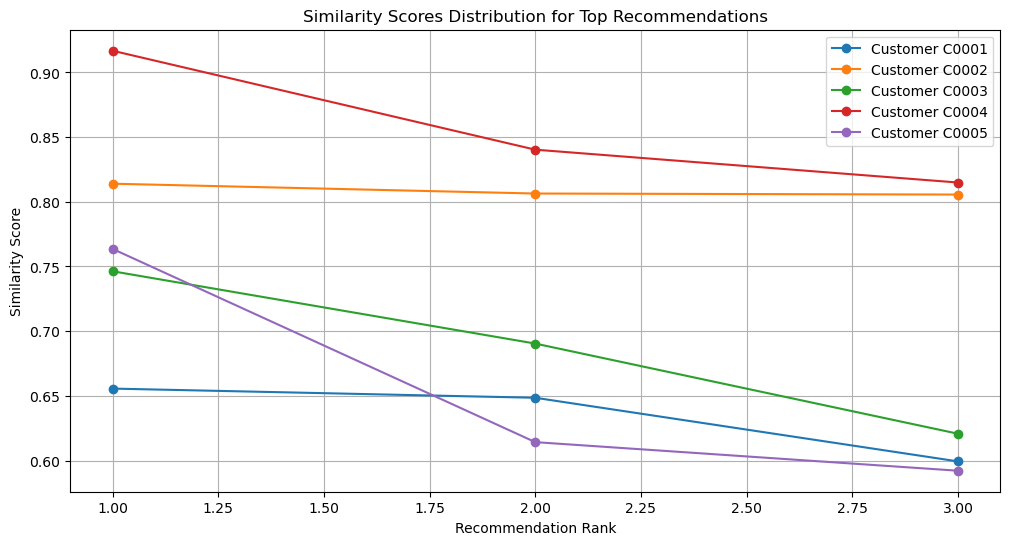

In [13]:
plt.figure(figsize=(12, 6))
for i, cust_id in enumerate(target_customers[:5]):
    scores = [score for _, score in similarity_results[cust_id]]
    plt.plot(range(1, 4), scores, marker='o', label=f'Customer {cust_id}')

plt.xlabel('Recommendation Rank')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores Distribution for Top Recommendations')
plt.legend()
plt.grid(True)
plt.show()

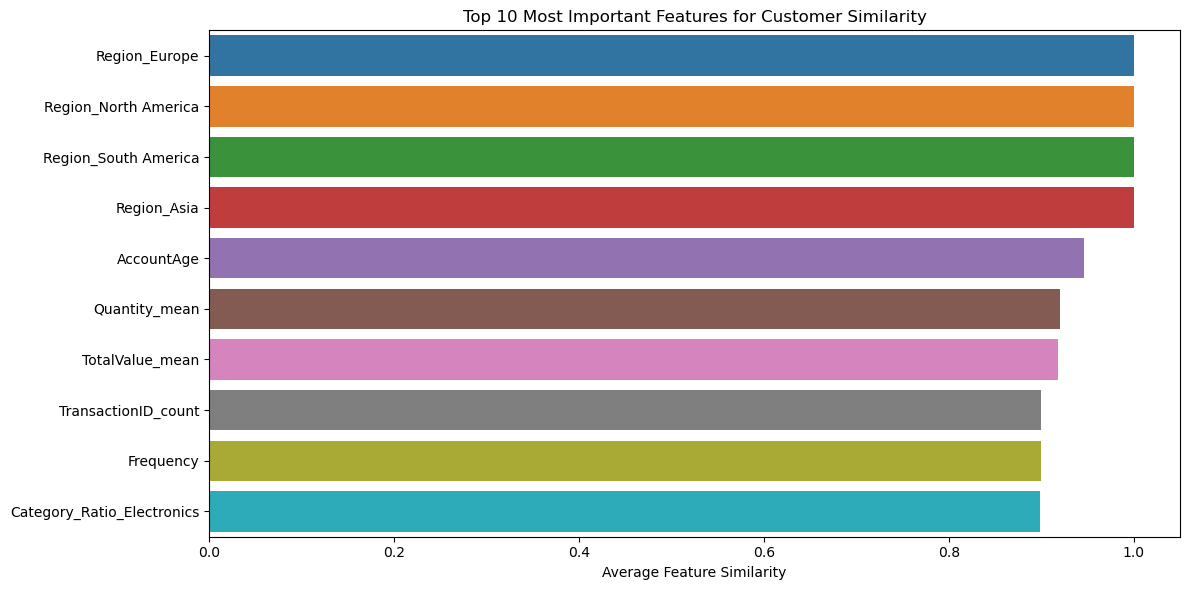

In [14]:
feature_importance = []
for cust_id in target_customers[:5]:  # Analyze first 5 customers for demonstration
    # Get customer features
    customer_features = final_features.loc[cust_id]
    
    # Get top recommendation features
    top_rec_id = similarity_results[cust_id][0][0]
    top_rec_features = final_features.loc[top_rec_id]
    
    # Calculate feature similarity
    feature_similarity = 1 - np.abs(customer_features - top_rec_features) / (customer_features + top_rec_features + 1e-10)
    feature_importance.append(feature_similarity)

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame(feature_importance, 
                                   index=target_customers[:5],
                                   columns=final_features.columns)

# Plot top 10 most important features
plt.figure(figsize=(12, 6))
feature_importance_mean = feature_importance_df.mean().sort_values(ascending=False)[:10]
sns.barplot(x=feature_importance_mean.values, y=feature_importance_mean.index)
plt.title('Top 10 Most Important Features for Customer Similarity')
plt.xlabel('Average Feature Similarity')
plt.tight_layout()
plt.show()

In [16]:
#exporting

lookalike_df.to_csv('Baswa_Tarun_Lookalike.csv', index=False)